# Notebook for launching tensorboard and track experiments

In [ ]:
## Launch tensorboard

In [1]:
import tensorboard

In [ ]:
!tensorboard --logdir="/home/matt/.qu/data/demo_segmentation/runs"

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [16]:
from pathlib import Path
a = "/home/matt/.qu/runs"

In [17]:
b = Path(a) / "blabla"

## Functions for detailed analysis of segmentation


In [361]:
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np 

def compare_images(truth_img_path, pred_img_path) ->None :
    """ compare ground truth and prediction visually higlihting errors
    @param: truth_image_path - path to grond truth mask
    @param: pred_img_path - path to prediction
    @return: None"""
    # import images
    if isinstance(truth_img_path, Path):
        truth_img_path = str(truth_img_path.resolve())
    if isinstance(pred_img_path, Path):
        pred_img_path = str(pred_img_path.resolve())
    truth_img = np.array(Image.open(truth_img_path))
    pred_img = np.array(Image.open(pred_img_path))
    # display differences
    truth_img = np.array(Image.open(truth_img_path))
     # difference in all classes
    gen_diff = truth_img != pred_img
    
    # difference for each classes
    class_list = list(np.unique(truth_img))[1:]
    print(class_list)
    fig,axs = plt.subplots(ncols=1, nrows=class_list[-1]+1, figsize=(30,35))
    for a,n in enumerate(class_list):
        t_im = truth_img.copy()
        t_im[ t_im != n ] = 0
        p_im = pred_img.copy()
        p_im[ p_im != n ] = 0
        
        axs[a].imshow(p_im != t_im)
        axs[a].set_title(f" difference in class {n}" )
        axs[a].set_axis_off()
    axs[class_list[-1]].imshow(gen_diff)
    axs[class_list[-1]].set_title("overall difference")
    axs[class_list[-1]].set_axis_off()
    return None

In [362]:
# object based analysis of results
import cv2

def get_contours(img) -> object:
    """get contours of  distinct objects in mask (ground truth or presentation)
    @param: img - 2d array with 0-3 values 
    @returns tuple with contour information, dist_transform array"""
    if np.max(img) != 255:
        img=np.array(img * (255/np.max(img)), dtype = np.uint8)
    
    dist_transform = cv2.distanceTransform(img,cv2.DIST_L1,5)
    ret, last_image =  cv2.threshold(dist_transform, 1e-06*dist_transform.max(),255,0)
    last_image = np.uint8(last_image)
    # get contours
    cnts = cv2.findContours(last_image.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
    return cnts, dist_transform

def count_cells(img) -> int:
    """counts distinct objects in mask 
    @param: img - 2d array with 0-3 values """
    cnts,_ = get_contours(img)
    return len(cnts[0])
    
def get_size_of_cells(img) -> list:
    """get cell size distribution in pixels
    @param: img - 2d array with 0-3 values 
    @returns list of cell sizes  """
    cnts, dist_transform =get_contours(img)
    size_list=[]
    for cnt in cnts[0]:
        bbox = cv2.boundingRect(cnt)
        bbox_remapped = [bbox[1], bbox[1]+bbox[3], bbox[0], bbox[0]+bbox[2]] 
        max_size = np.max(dist_transform[bbox_remapped[0] : bbox_remapped[1], 
                                         bbox_remapped[2] : bbox_remapped[3] ])
        size_list.append(int(max_size))
    return size_list

def detect_partial_segmentation(img):
    """ evaluate prediction quality of contour (class 2) vs actual cell (class 1)
    @param: img - 2d array with 0-3 values 
    @returns count of wrong cells
    """
    cnts, dist_transform =get_contours(img)
    size_list=[]
    problem_list = []
    for cnt in cnts[0]:
        bbox = cv2.boundingRect(cnt)
        bbox_remapped = [bbox[1], bbox[1]+bbox[3], bbox[0], bbox[0]+bbox[2]] 
        aoi_dist = dist_transform[ bbox_remapped[0] : bbox_remapped[1], 
                                   bbox_remapped[2] : bbox_remapped[3] ]
        aoi = img[ bbox_remapped[0] : bbox_remapped[1], 
                   bbox_remapped[2] : bbox_remapped[3] ]
        contour = np.ma.masked_where(aoi_dist>2, aoi)
        inner = np.ma.masked_where(aoi_dist<=2, aoi)
    if (1 in np.unique(contour)) or (1 not in np.unique(inner) ):
        problem_list.append(cnt)
        
    return problem_list


In [398]:
# batch assessment
import os
from statistics import mean, stdev

def check_segmentation_predictions(gt_fold_path, pred_fold_path, verbose=False):
    """wrapper to evaluate segmentation quality in batch of images. 
    All errors are expressed as prediction - ground truth
    
    @param: gt_fold_path - path to ground truth folder
    @param: pred_fold_path - path to predictions 
    @param: verbose - Bool or int <= 2"""
    missing_files = []
    d,_,f = list(os.walk(gt_fold_path))[0]
    d1,_,f1= list(os.walk(pred_fold_path))[0]
    
    # check for missing files
    
    if verbose:
        print(f"found {len(f)} ground truth and {len(f1)} predictions")
   
    clean_fnames = sorted([f_name.split("_")[-1]  for f_name in f])
    clean_f1names = sorted([f_name.split("_")[-1]  for f_name in f1])

    missing_files = [f for f in clean_fnames if f not in clean_f1names]
    if len(missing_files)>0:
        print(f"{len(missing_files)} missing images found: {missing_files} ")
    
    # detect segmentation errors per image
    un_objects_diff = []
    size_difference = []
    partial_segmentations = []
    
    for n in range(len(f)):
        true_img_path = os.path.join(d, f[n])
        pred_img_path = os.path.join(d1, f1[n])
        if verbose>1:
            print(f"evaluating img {f[n]} and prediction {f1[n]}")
        
        tr_img = np.array(Image.open(true_img_path))
        pr_img = np.array(Image.open(pred_img_path))
                
        # count distinct objects / cells
        un_objects_diff.append( count_cells(pr_img) - count_cells(tr_img) )

        if verbose>1:
            print(f"number of unique objects: {count_cells(pr_img)}, {count_cells(tr_img)} \n")
                  
        # get difference in avg and std of cell sizes
        avg_diff = mean(get_size_of_cells(pr_img)) - mean(get_size_of_cells(tr_img))
        std_diff = stdev(get_size_of_cells(pr_img)) - stdev(get_size_of_cells(tr_img))
        size_difference.append( [avg_diff, std_diff] )
        
        # get partial segmentations (predictions only)
        partial_segmentations.append( len(detect_partial_segmentation(pr_img)) )
    
    segmentation_errors={"un_objects_diff": un_objects_diff, 
                         "size_difference": size_difference, 
                         "partial_segmentations": partial_segmentations
                            }
        
    if verbose:
    # create plots on errors
        fig, axs=plt.subplots(ncols=2, nrows=2, figsize=(10,25))
        axs[0].boxplot(segmentation_errors["un_objects_diff"])
        axs[1].boxplot( [np.array(segmentation_errors["size_difference"]).squeeze()[:,0],
                        np.array(segmentation_errors["size_difference"]).squeeze()[:,1] ])
        axs[2].hist(segmentation_errors["partial_segmentations"])
        
        axs[0].set_title("difference in unique objects count (prediction - ground truth)")
        axs[1].set_title("difference in pixel size of object (prediction - ground truth)")
        axs[2].set_title("partial segmentations in prediction ")
        
            
    return segmentation_errors

found 90 ground truth and 90 predictions


AttributeError: 'numpy.ndarray' object has no attribute 'boxplot'

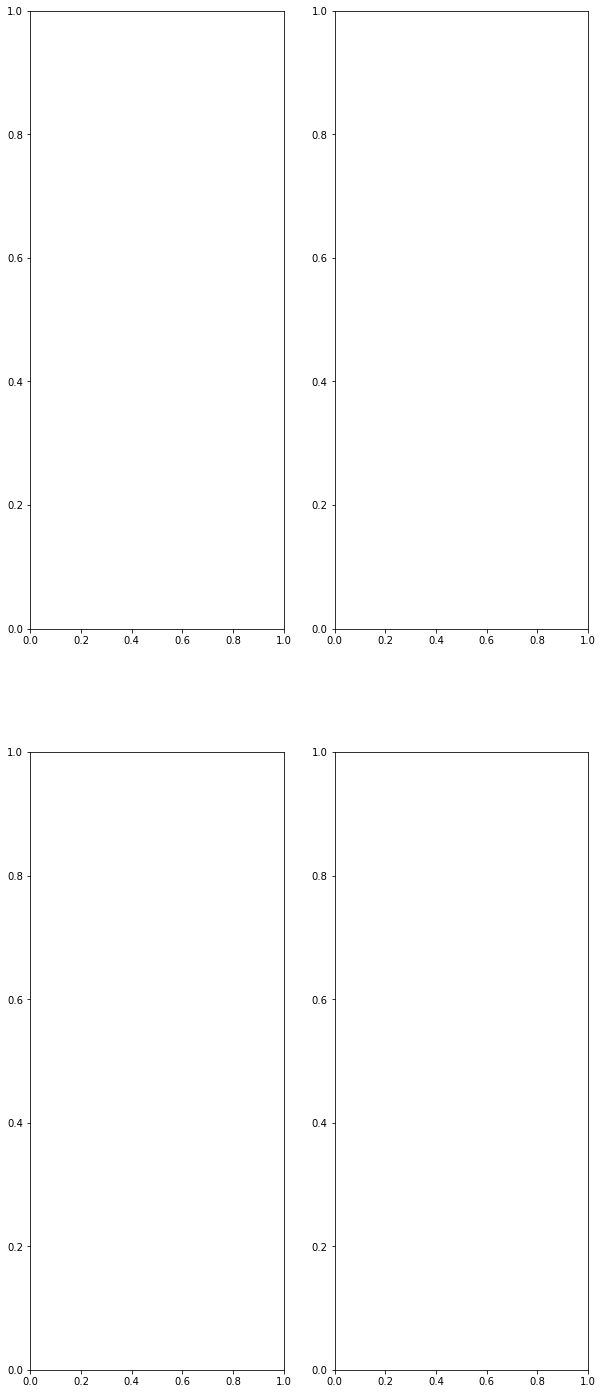

In [399]:
# running assessment

gt_fold_path = "/home/matt/.qu/data/demo_segmentation/masks"

pred_fold_path = "/home/matt/.qu/data/demo_segmentation/preds"

_ = check_segmentation_predictions(gt_fold_path, pred_fold_path, True)